## Import

In [1]:
import os
import random

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.utils.data as torchdata
import umap
import cv2

from pathlib import Path

from albumentations.pytorch import ToTensorV2
from catalyst.dl import SupervisedRunner, Runner
from catalyst.core import Callback, CallbackOrder, IRunner
from sklearn.model_selection import KFold
from tqdm import tqdm

## Settings

In [2]:
sns.set_context("talk")
plt.style.use("ggplot")

In [3]:
DATA_PATH = "/home/knikaido/work/atma10/data/"
TRAIN_PATH = DATA_PATH + "train.csv"
TEST_PATH = DATA_PATH + "test.csv"
SUB_PATH = DATA_PATH + "atmacup10__sample_submission.csv"

In [4]:
SEED = 42
N_SPLITS = 5
SHUFFLE = True
EPOCH = 50
OUTPUT_DIR = './output/'

DATASET_CONFIG = {
    'loader': {
      'train': {
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 1,
        'pin_memory': True,
        'drop_last': True,
      },
      'valid': {
        'batch_size': 2,
        'shuffle': False,
        'num_workers': 1,
        'pin_memory': True,
        'drop_last': True,
      }
    }
}

config = DATASET_CONFIG
SAVE_TEST_SUB_PATH = "sub05.csv"

## Utility

In [5]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
set_seed(SEED)

In [6]:
palette = pd.read_csv(DATA_PATH + "palette.csv")
palette.head()

,ratio,color_r,color_g,color_b,object_id
0,0.013781,40,4,0,000405d9a5e3f49fc49d
1,0.040509,221,189,129,000405d9a5e3f49fc49d
2,0.036344,207,175,117,000405d9a5e3f49fc49d
3,0.033316,230,197,129,000405d9a5e3f49fc49d
4,0.039600,194,161,106,000405d9a5e3f49fc49d


In [7]:
# パーセント表示に直して四捨五入
palette["ratio_int"] = palette["ratio"].map(lambda x: int(np.round(100 * x)))

# `object_id`で集約してratio_intを足し合わせると100を超えたり100に満たない場合がある
palette.groupby("object_id")["ratio_int"].sum()

object_id
000405d9a5e3f49fc49d    100
001020bd00b149970f78    100
0011d6be41612ec9eae3    100
0012765f7a97ccc3e9e9    102
00133be3ff222c9b74b0    103
                       ... 
fff4bbb55fd7702d294e    101
fffbe07b997bec00e203     99
fffd1675758205748d7f    100
fffd43b134ba7197d890     99
ffff22ea12d7f99cff31    100
Name: ratio_int, Length: 23995, dtype: int64

In [8]:
# `object_id`で集約した時に足し合わせてちょうど100になるようにする
palette_group_dfs = []
for _, df in tqdm(palette.groupby("object_id"),
                  total=palette["object_id"].nunique()):
    # 足し合わせた和が100を超過する場合
    if df["ratio_int"].sum() > 100:
        n_excess = df["ratio_int"].sum() - 100
        # ちょっと雑だが一番比率が多い色の割合を減らすことで和を100に揃える
        max_ratio_int_idx = df["ratio_int"].idxmax()
        df.loc[max_ratio_int_idx, "ratio_int"] -= n_excess
    elif df["ratio_int"].sum() < 100:
        n_lack = 100 - df["ratio_int"].sum()
        max_ratio_int_idx = df["ratio_int"].idxmax()
        df.loc[max_ratio_int_idx, "ratio_int"] += n_lack
    else:
        pass
    palette_group_dfs.append(df)

new_palette = pd.concat(palette_group_dfs, axis=0).reset_index(drop=True)

100%|██████████| 23995/23995 [00:10<00:00, 2339.93it/s]


In [9]:
# `object_id`で集約してratio_intを足し合わせるとちょうど100になる
new_palette.groupby("object_id")["ratio_int"].sum()

object_id
000405d9a5e3f49fc49d    100
001020bd00b149970f78    100
0011d6be41612ec9eae3    100
0012765f7a97ccc3e9e9    100
00133be3ff222c9b74b0    100
                       ... 
fff4bbb55fd7702d294e    100
fffbe07b997bec00e203    100
fffd1675758205748d7f    100
fffd43b134ba7197d890    100
ffff22ea12d7f99cff31    100
Name: ratio_int, Length: 23995, dtype: int64

In [10]:
def _create_random_image(sample: pd.DataFrame) -> np.ndarray:
    """
    配置はランダムで色の比率がsampleで指示された値になるようにした
    10x10の画像を生成する
    """
    # まず一次元で定義しておく
    image = np.zeros((100, 3), dtype=np.uint8)
    # sampleの頭から1行ずつその行の色をその行のratio_int分だけコピーして画像を埋める
    head = 0
    for i, row in sample.iterrows():
        # sampleの行に書かれた色
        patch = np.array([[row.color_r, row.color_g, row.color_b]], dtype=np.uint8)
        # sampleの行に書かれたratio_int分だけコピーする
        patch = np.tile(patch, row.ratio_int).reshape(row.ratio_int, -1)
        # 画像を上の手順で出した色で埋める
        image[head:head + row.ratio_int, :] = patch
        head += row.ratio_int
    # 乱数で順番をランダム化する
    indices = np.random.permutation(np.arange(100))
    image = image[indices, :].reshape(10, 10, 3)
    image = cv2.resize(image, (224, 224))
    return image

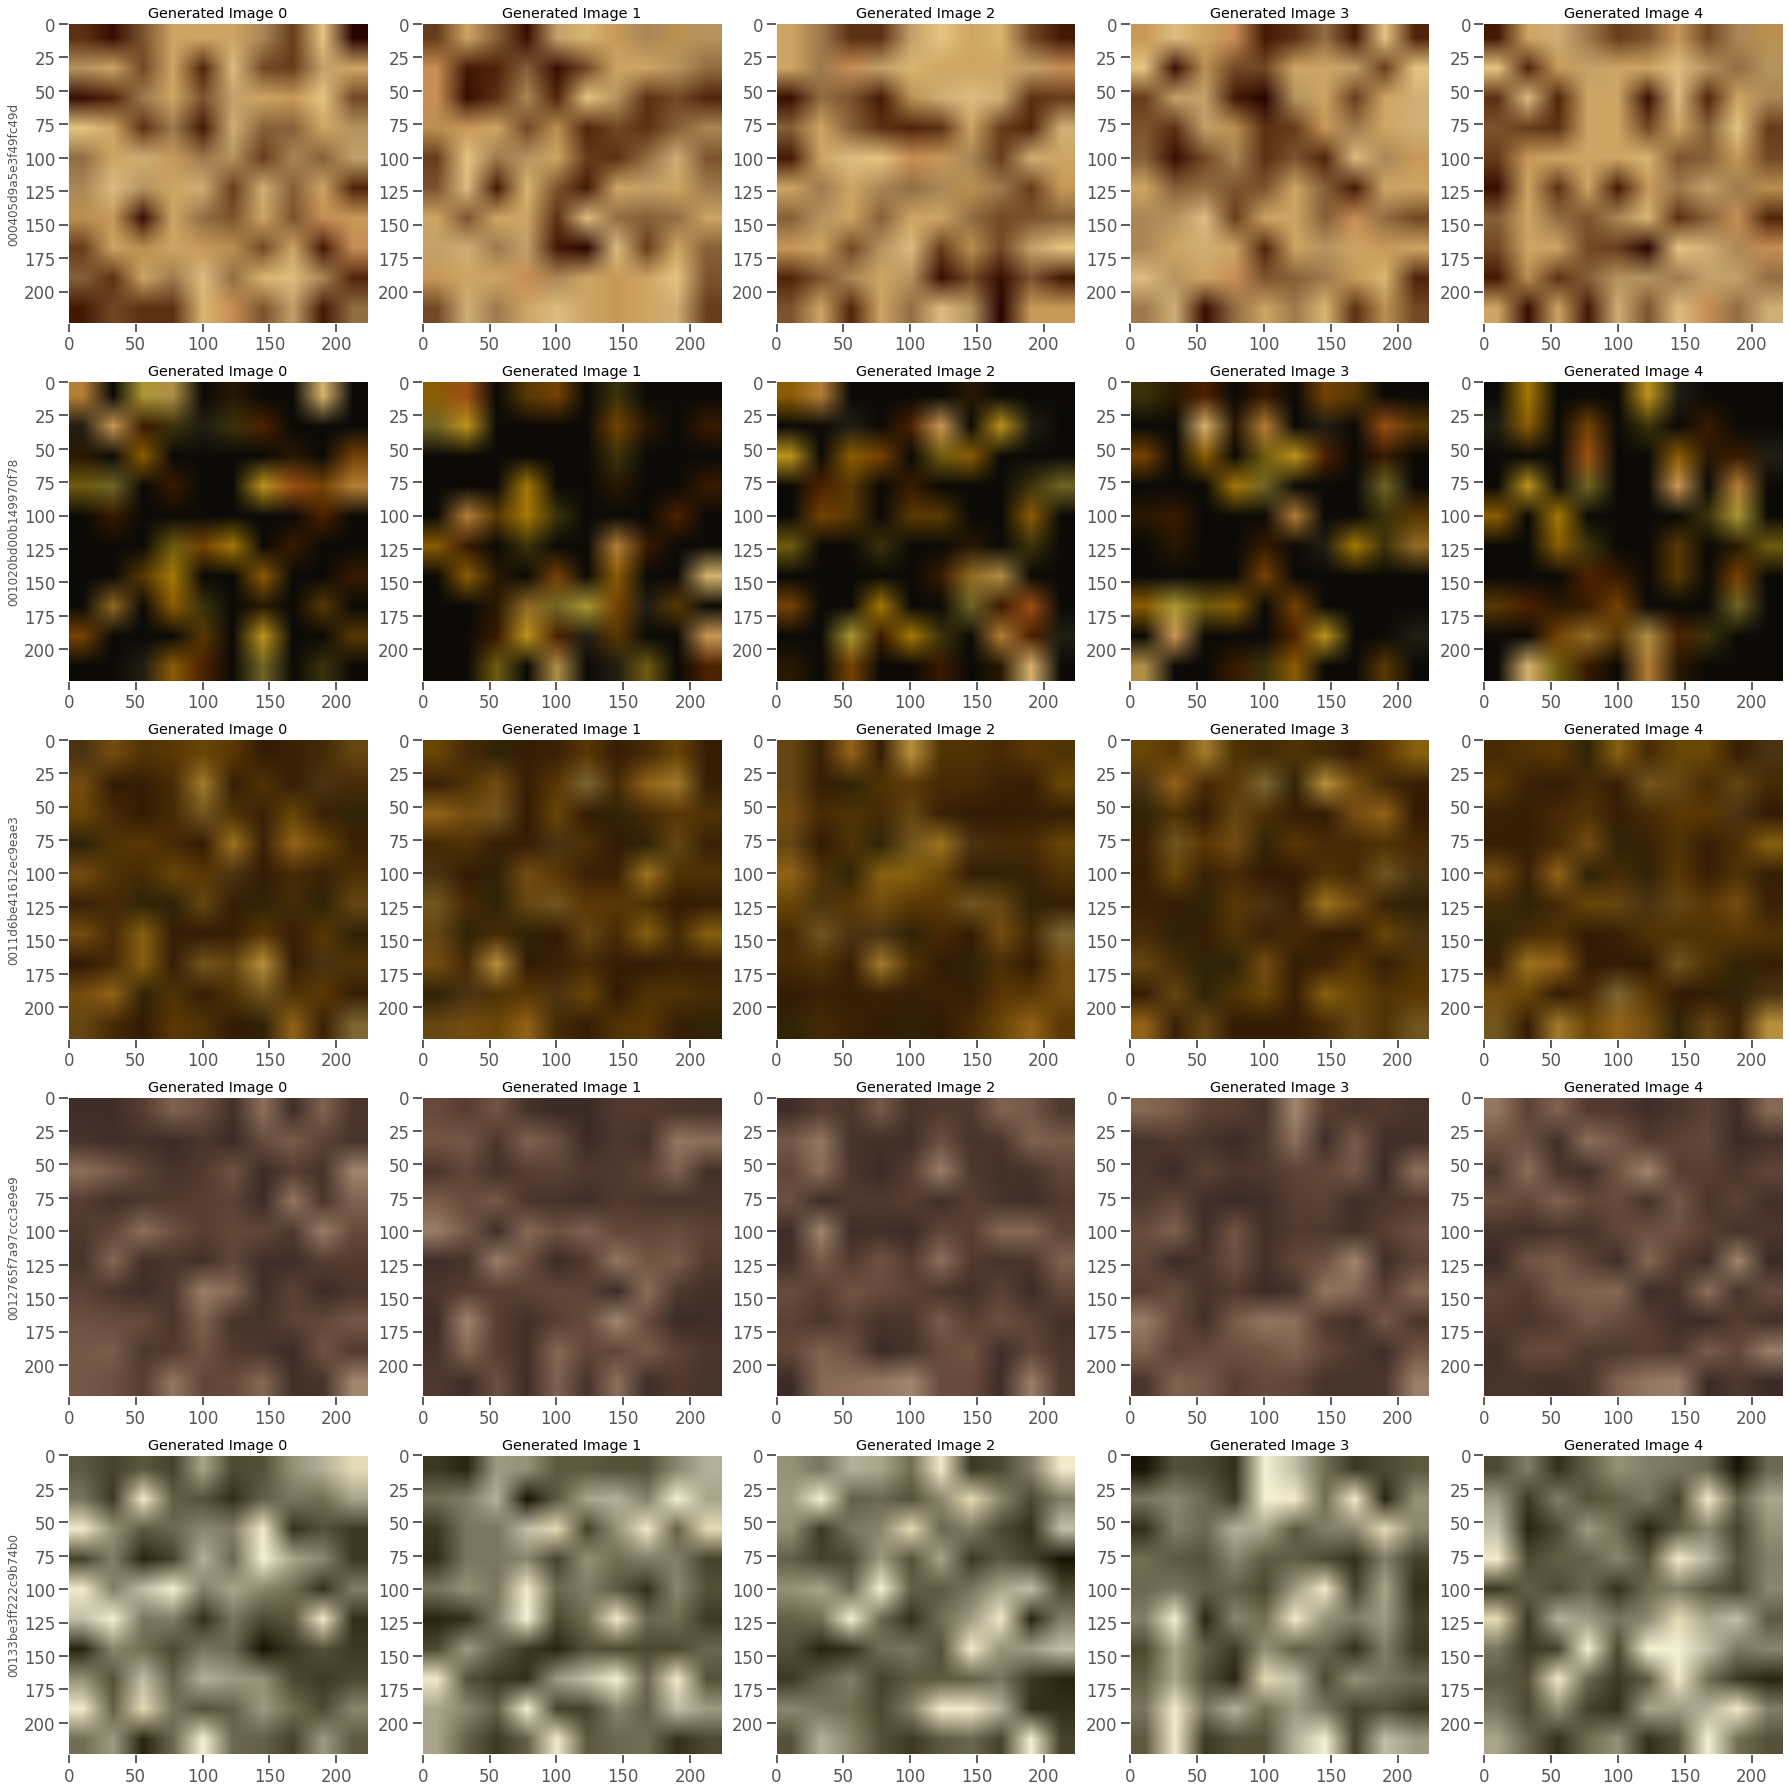

In [11]:
unique_object_ids = new_palette["object_id"].unique()
N_IMAGES_FOR_OBJ_ID = 5
N_OBJ_IDS = 5

fig, axes = plt.subplots(nrows=N_OBJ_IDS, ncols=N_IMAGES_FOR_OBJ_ID, figsize=(25, 25))
for i in range(N_OBJ_IDS):
    obj_id = unique_object_ids[i]
    palette_obj_id = new_palette.query(f"object_id == '{obj_id}'")
    axes[i, 0].set_ylabel(obj_id)
    for j in range(N_IMAGES_FOR_OBJ_ID):
        generated = _create_random_image(palette_obj_id)
        axes[i, j].imshow(generated)
        axes[i, j].grid(False)
        axes[i, j].set_title(f"Generated Image {j}")

plt.tight_layout()
plt.show()

In [12]:
class ColorImageDataset(torchdata.Dataset):
    def __init__(self, df: pd.DataFrame, transforms=None):
        self.object_id = df["object_id"].unique()
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.object_id)

    def __getitem__(self, idx: int):
        object_id = self.object_id[idx]
        sample = self.df.query(f"object_id == '{object_id}'")[
            ["ratio_int", "color_r", "color_g", "color_b"]]
        # 負例のサンプリングを行う
        while True:
            neg_sample_id = np.random.choice(self.object_id)
            if neg_sample_id != object_id:
                break
        neg_sample = self.df.query(f"object_id == '{neg_sample_id}'")[
            ["ratio_int", "color_r", "color_g", "color_b"]]

        # アンカー画像の生成
        anchor = _create_random_image(sample)
        # 正例の生成
        pos = _create_random_image(sample)
        # 負例の生成
        neg = _create_random_image(neg_sample)

        anchor = self.transforms(image=anchor)["image"]
        pos = self.transforms(image=pos)["image"]
        neg = self.transforms(image=neg)["image"]
        return anchor, pos, neg

In [13]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3))

    def forward(self, x):
        return self.cnn_encoder(x).mean(dim=[2, 3])

In [14]:
class ResNetSimCLR(nn.Module):

    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)

        # add mlp projection head
        self.ln = nn.Sequential(nn.Linear(1000, 512), nn.ReLU(), nn.Linear(512, 64))

    def forward(self, x):
        x = self.backbone(x)
        x = self.ln(x)
        return x

In [15]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.cos = nn.CosineSimilarity()

    def forward(self, anchor, pos, neg):
        pos_loss = 1.0 - self.cos(anchor, pos).mean(dim=0)
        neg_loss = self.cos(anchor, neg).mean(dim=0)
        return pos_loss + neg_loss

In [16]:
class ContrastRunner(Runner):
    def predict_batch(self, batch, **kwargs):
        return super().predict_batch(batch, **kwargs)

    def _handle_batch(self, batch):
        anchor, pos, neg = batch[0], batch[1], batch[2]
        anchor = anchor.to(self.device)
        pos = pos.to(self.device)
        neg = neg.to(self.device)

        anchor_emb = self.model(anchor)
        pos_emb = self.model(pos)
        neg_emb = self.model(neg)

        loss = self.criterion(anchor_emb, pos_emb, neg_emb)
        self.batch_metrics.update({
            "loss": loss
        })

        self.input = batch
        if self.is_train_loader:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

In [17]:
class SchedulerCallback(Callback):
    def __init__(self):
        super().__init__(CallbackOrder.Scheduler)

    def on_loader_end(self, state: IRunner):
        lr = state.scheduler.get_last_lr()
        state.epoch_metrics["lr"] = lr[0]
        if state.is_train_loader:
            state.scheduler.step()

In [18]:
OUTDIR = Path("./output/PaletteEmbedding_res")
OUTDIR.mkdir(exist_ok=True, parents=True)

In [ ]:
# kf = KFold(n_splits=5, random_state=1213, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unique_obj_id = new_palette["object_id"].unique()
# for fold, (trn_idx, val_idx) in enumerate(kf.split(unique_obj_id)):
print("*" * 100)
# print(f"Fold: {fold}")

trn_obj_id = unique_obj_id
#     val_obj_id = unique_obj_id[val_idx]

trn_palette = new_palette[
    new_palette["object_id"].isin(trn_obj_id)
].reset_index(drop=True)
#     val_palette = new_palette[
#         new_palette["object_id"].isin(val_obj_id)
#     ].reset_index(drop=True)

transforms = A.Compose([A.Normalize(), ToTensorV2()])
trn_dataset = ColorImageDataset(trn_palette, transforms)
#     val_dataset = ColorImageDataset(val_palette, transforms)

trn_loader = torchdata.DataLoader(
    trn_dataset, batch_size=16, shuffle=True, num_workers=1)
#     val_loader = torchdata.DataLoader(
#         val_dataset, batch_size=256, shuffle=False, num_workers=20)

model = ResNetSimCLR().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
callbacks = [SchedulerCallback()]
runner = ContrastRunner(device=device)
runner.train(model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=scheduler,
             callbacks=callbacks,
             loaders={"train": trn_loader},
             num_epochs=30,
             logdir=OUTDIR,
             verbose=False)

****************************************************************************************************


/home/user/.local/lib/python3.6/site-packages/catalyst/experiments/experiment.py:221: UserWarning:

Attention, there is only one dataloader - train



[2021-03-11 15:37:22,257] 
1/30 * Epoch 1 (_base): lr=0.0010
1/30 * Epoch 1 (train): loss=0.0502
[2021-03-11 15:46:49,094] 
2/30 * Epoch 2 (_base): lr=0.0010
2/30 * Epoch 2 (train): loss=0.0184
[2021-03-11 15:56:14,582] 
3/30 * Epoch 3 (_base): lr=0.0009
3/30 * Epoch 3 (train): loss=0.0198
[2021-03-11 16:05:36,069] 
4/30 * Epoch 4 (_base): lr=0.0008
4/30 * Epoch 4 (train): loss=0.0135
[2021-03-11 16:14:56,819] 
5/30 * Epoch 5 (_base): lr=0.0007
5/30 * Epoch 5 (train): loss=0.0011
[2021-03-11 16:24:24,025] 
6/30 * Epoch 6 (_base): lr=0.0005
6/30 * Epoch 6 (train): loss=0.0208
[2021-03-11 16:33:46,665] 
7/30 * Epoch 7 (_base): lr=0.0003
7/30 * Epoch 7 (train): loss=0.0161
[2021-03-11 16:43:13,671] 
8/30 * Epoch 8 (_base): lr=0.0002
8/30 * Epoch 8 (train): loss=-3.867e-03
[2021-03-11 16:52:35,468] 
9/30 * Epoch 9 (_base): lr=9.549e-05
9/30 * Epoch 9 (train): loss=0.0047
[2021-03-11 17:01:55,687] 
10/30 * Epoch 10 (_base): lr=2.447e-05
10/30 * Epoch 10 (train): loss=-3.803e-03
[2021-03-11 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unique_obj_id = new_palette["object_id"].unique()
transforms = A.Compose([A.Normalize(), ToTensorV2()])

embeddings = []
object_ids = []
# for fold, (_, val_idx) in enumerate(kf.split(unique_obj_id)):
val_obj_id = unique_obj_id
val_palette = new_palette[
    new_palette["object_id"].isin(val_obj_id)
].reset_index(drop=True)
val_dataset = ColorImageDataset(val_palette, transforms)
object_ids.extend(val_dataset.object_id.tolist())

val_loader = torchdata.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=20)
model = ResNetSimCLR()
ckpt = torch.load(OUTDIR / f"checkpoints/best.pth")
model.load_state_dict(ckpt["model_state_dict"])
model.to(device)
model.eval()
# アンカー画像にのみ推論
for anchor, _, _ in tqdm(val_loader):
    anchor = anchor.to(device)
    with torch.no_grad():
        embedding = model(anchor).detach().cpu().numpy()
    embeddings.append(embedding)

In [ ]:
all_embeddings = np.concatenate(embeddings, axis=0)
len(all_embeddings), len(object_ids)

In [ ]:
embedding_df = pd.DataFrame(all_embeddings, 
                            columns=[f"color_embedding_{i}" for i in range(len(all_embeddings[0]))],
                            index=object_ids)
embedding_df.head()

In [ ]:
embedding_df.values

In [ ]:
reducer = umap.UMAP(random_state=42)
reduced = reducer.fit_transform(embedding_df.values)
umap_df = pd.DataFrame(reduced, columns=["dim0", "dim1"], index=embedding_df.index)
umap_df.head()

In [ ]:
train = pd.read_csv(DATA_PATH + "train.csv")
train["likes"] = np.log1p(train["likes"])
likes_df = train[["object_id", "likes"]]
likes_df.head()

In [ ]:
likes_df = likes_df.merge(umap_df, left_on="object_id", right_index=True, how="left")
likes_df

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="dim0", y="dim1", hue="likes", data=likes_df, alpha=0.5);

In [29]:
embedding_df_output = embedding_df.reset_index()
embedding_df_output = embedding_df_output.rename(columns={"index":"object_id"})
embedding_df_output

,object_id,color_embedding_0,color_embedding_1,color_embedding_2,color_embedding_3,color_embedding_4,color_embedding_5,color_embedding_6,color_embedding_7,color_embedding_8,...,color_embedding_54,color_embedding_55,color_embedding_56,color_embedding_57,color_embedding_58,color_embedding_59,color_embedding_60,color_embedding_61,color_embedding_62,color_embedding_63
0,000405d9a5e3f49fc49d,-162.362488,237.084427,-343.717194,21.719046,-160.168869,-389.485535,-493.753418,-92.676155,99.501350,...,132.979019,-15.716493,-294.578979,-160.294174,-156.247070,-301.915527,-18.515362,135.868103,-394.075439,307.492493
1,001020bd00b149970f78,-138.974365,193.831116,-301.592529,23.327114,-138.455521,-340.883057,-427.847687,-63.146900,87.563087,...,105.877510,-24.915134,-272.158539,-141.945969,-132.673370,-260.442932,-10.642682,133.762833,-337.730621,266.685272
2,0011d6be41612ec9eae3,-114.192238,158.949203,-247.210266,19.226120,-113.424522,-279.220825,-351.007202,-51.972431,71.711113,...,87.065735,-20.272333,-223.034286,-116.443871,-109.090683,-213.379105,-8.905723,109.661537,-276.930176,218.944275
3,0012765f7a97ccc3e9e9,-90.227951,119.921761,-203.020355,14.945296,-88.868919,-228.367996,-284.024261,-35.017799,57.736557,...,66.743248,-22.508574,-188.659943,-97.617569,-89.392906,-170.281708,-5.468223,97.727882,-221.712723,178.366043
4,00133be3ff222c9b74b0,21.728230,49.857128,165.845337,-0.674469,15.465782,178.429565,130.529205,-116.128494,-70.714554,...,29.039612,117.135727,229.081299,122.687210,58.106731,66.920860,-53.437763,-193.409485,78.564125,-127.903053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23990,fff4bbb55fd7702d294e,58.206196,-132.228683,59.798290,-12.192835,60.576511,71.422134,146.655106,106.569778,-4.454167,...,-72.031433,-56.834175,1.725649,2.683393,35.627365,98.524239,34.914494,51.579548,130.215988,-62.517975
23991,fffbe07b997bec00e203,63.089214,-133.260452,92.549644,-12.821489,66.352974,108.534088,179.172607,90.996307,-15.202232,...,-72.420479,-41.300117,41.180412,25.550060,46.584839,110.161842,30.477264,16.186949,151.416229,-90.689728
23992,fffd1675758205748d7f,-277.242157,482.774414,-482.879089,29.246811,-268.007355,-542.420105,-766.461182,-259.700317,122.919746,...,267.243317,79.837761,-317.251984,-195.153076,-232.211884,-476.916656,-69.078506,75.068130,-640.867188,459.220215
23993,fffd43b134ba7197d890,60.583824,-135.514053,70.425705,-12.725568,63.636322,83.858871,159.068512,104.739571,-7.472091,...,-73.834366,-53.989208,12.758335,9.161366,39.463795,103.864174,34.460922,43.133381,138.870834,-71.481003


In [30]:
embedding_df_output.to_csv(DATA_PATH + 'color_emb_res.csv', index=False)